- In this lesson, we will practice forecasting using the following methods:
    - Last observed value
    - Simple average
    - Moving average
    - Holt's Linear Trend
    - Previous cycle
- We will walk through steps from previous lessons to get the data ready to model
    - Acquire data: prepare.acquire_store_data()
    - Prepare data: prepare.prep_store_data()
    - Split data: prepare.split_store_data()


Then we will forecast and evaluate using each method.

In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt 

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import prepare

In [7]:
df = pd.read_csv('sales.csv', index_col = 0)

In [8]:
df = prepare.prep_sales_df(df)

In [10]:
df = df[['quantity', 'sales_total']]

In [20]:
df = df.groupby(['sale_date'])[['quantity', 'sales_total']].sum().reset_index().set_index('sale_date')

In [21]:
# remove leap days

df = df[df.index != '2016-02-29']

### Split
1. We will use the training proportion method to split.
2. Identify the total length of the dataframe and multiply by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
4. Return train and test dataframes.

In [22]:
train_size = int(len(df) * .5)
train_size

912

In [23]:
validate_size = int(len(df) * .3)
validate_size

547

In [24]:
test_size = int(len(df) - train_size - validate_size)
test_size

366

In [25]:
validate_end_index = train_size + validate_size
validate_end_index

1459

Use those valyes to split our dataframe

In [26]:
train = df[: train_size]
validate = df[train_size:validate_end_index]
test = df[validate_end_index:]

**Verify Splits**

Does the length of each df equal to the length of the original df?

In [29]:
print(len(train) + len(validate) + len(test) == len(df))

True



Does the first row of original df equate to the first row of train?

In [30]:
print(df.head(1) == train.head(1))

                           quantity  sales_total
sale_date                                       
2013-01-01 00:00:00+00:00      True         True



Is the last row of train the day before the first row of validate? And the same for validate to test?

In [31]:
pd.concat([train.tail(1), validate.head(1)])

,quantity,sales_total
sale_date,,
2015-07-01 00:00:00+00:00,30703.0,164573.20
2015-07-02 00:00:00+00:00,33134.0,178036.64


In [32]:
pd.concat([validate.tail(1), test.head(1)])


,quantity,sales_total
sale_date,,
2016-12-30 00:00:00+00:00,22296.0,120033.64
2016-12-31 00:00:00+00:00,23792.0,128009.31


Is the last row of test the same as the last row of our original dataframe?


In [33]:
pd.concat([test.tail(1), df.tail(1)])


,quantity,sales_total
sale_date,,
2017-12-31 00:00:00+00:00,26420.0,140905.74
2017-12-31 00:00:00+00:00,26420.0,140905.74


Let's plot our data first, viewing where the data is split into train and test.


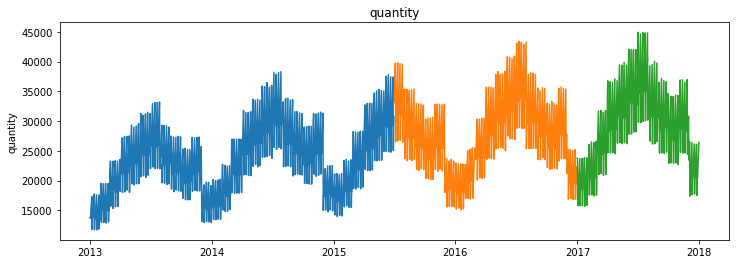

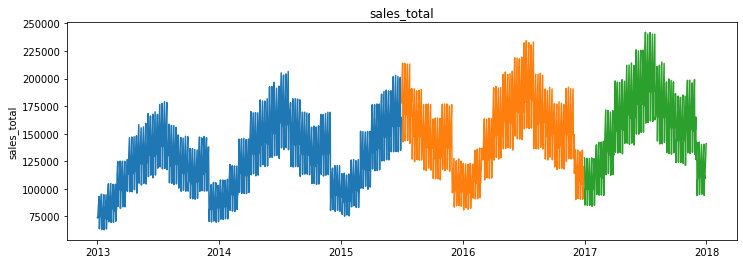

In [34]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

- Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.


- evaluate() will compute the Mean Squared Error and the Rood Mean Squared Error to evaluate.


In [35]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

- plot_and_eval() will use the evaluate function from above and also plot train and test values with the predicted values in order to compare performances

In [67]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var,  '--RMSE: {:.0f}'.format(rmse))
    plt.show()

Write append_eval_df(model_type) to append evaluation metrics for each model type, target variable, and metric type, along with the metric value into our eval_df data frame object. Which we will create an empty eval_df dataframe object to start.

In [68]:

# creating an empty dataframe to store the model type, the target val, and the eval metrics(rmse)
eval_df = pd.DataFrame(columns = ['model_type', 'target_var', 'rmse'])


In [69]:
# lets create a function that appends the rmse so that we can compare between different variables

def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

### Forecast
- Forecasting is another word for predicting time series data.
    - Last Observed Value
    - Simple Average
    - Moving Average
    - Holt's Linear Trend
    - Previous Cycle
    
**Last observed value**

- The simplest method for forecasting is to predict all future values to be the last observed value.


**Make Predictions**

Dollars

In [70]:
dollars = round(train['sales_total'][-1:][0], 2)
dollars

164573.2

In [71]:
quantity = train['quantity'][-1:][0]
quantity

30703.0

In [72]:
# This is our prediction dataframe using the last value method

yhat_df = pd.DataFrame({'sales_total': [dollars], 'quantity': [quantity]}, index = validate.index)

In [73]:
# lets take a look into our predicted dataframe

yhat_df

,sales_total,quantity
sale_date,,
2015-07-02 00:00:00+00:00,164573.2,30703.0
2015-07-03 00:00:00+00:00,164573.2,30703.0
2015-07-04 00:00:00+00:00,164573.2,30703.0
2015-07-05 00:00:00+00:00,164573.2,30703.0
2015-07-06 00:00:00+00:00,164573.2,30703.0
...,...,...
2016-12-26 00:00:00+00:00,164573.2,30703.0
2016-12-27 00:00:00+00:00,164573.2,30703.0
2016-12-28 00:00:00+00:00,164573.2,30703.0


**Lets plot actual vs Predicted**

sales_total --RMSE: 35402


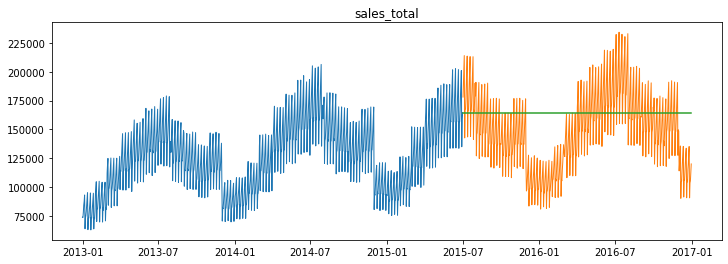

In [74]:
plot_and_eval('sales_total')

quantity --RMSE: 6621


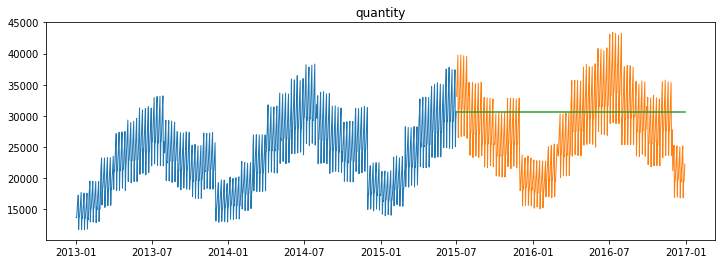

sales_total --RMSE: 35402


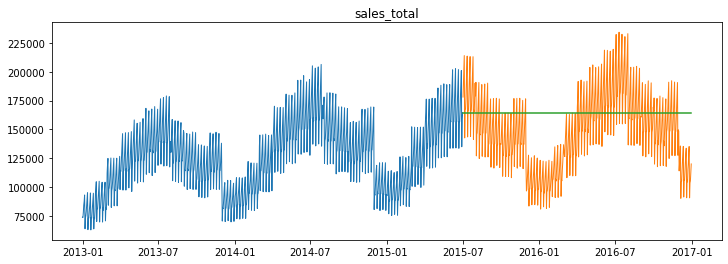

In [75]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**

In [76]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
1,last_observed_value,sales_total,35402.0


### Simple Average
- Take the simple average of historical values and use that value to predict future values.
- This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

**Make Predictions**

Dollars: establishing the value of the prediction we will make


In [77]:
# compute the simple average
dollars = round(train['sales_total'].mean(), 2)
dollars

127517.85

Items: establishing the value of the prediction we will make

In [78]:
items = round(train['quantity'].mean(), 2)
items

23717.94

In [80]:
def make_predictions():
    yhat_df = pd.DataFrame({'sales_total': [dollars], 'quantity':[items]}, index = validate.index)
    
    return yhat_df

In [83]:
yhat_df = make_predictions()

In [84]:
yhat_df

,sales_total,quantity
sale_date,,
2015-07-02 00:00:00+00:00,127517.85,23717.94
2015-07-03 00:00:00+00:00,127517.85,23717.94
2015-07-04 00:00:00+00:00,127517.85,23717.94
2015-07-05 00:00:00+00:00,127517.85,23717.94
2015-07-06 00:00:00+00:00,127517.85,23717.94
...,...,...
2016-12-26 00:00:00+00:00,127517.85,23717.94
2016-12-27 00:00:00+00:00,127517.85,23717.94
2016-12-28 00:00:00+00:00,127517.85,23717.94


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using **Simple Average**

quantity --RMSE: 7378


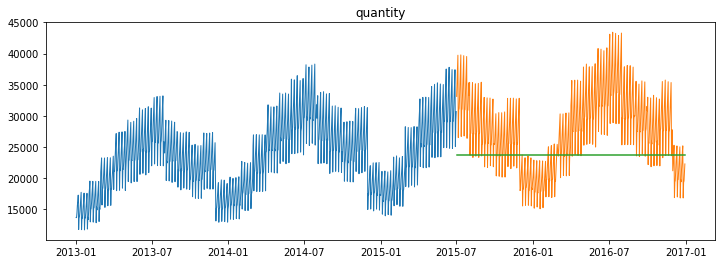

sales_total --RMSE: 39664


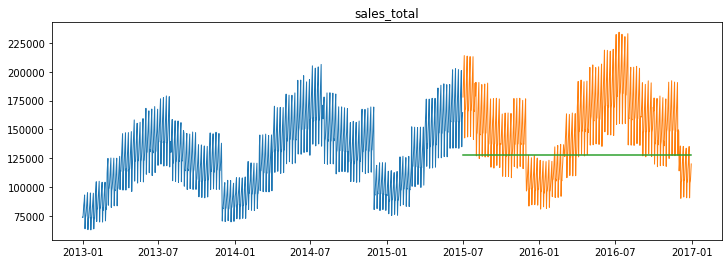

In [85]:
for col in train.columns:
    plot_and_eval(col)


**Evaluate**

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [87]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'simple_average', target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
1,last_observed_value,sales_total,35402.0
2,simple_average,quantity,7378.0
3,simple_average,sales_total,39664.0


### Moving Average

- In this example, we will use a 30-day moving average to forecast. In other words, the average of the last 30 days will be used as a forecasted value

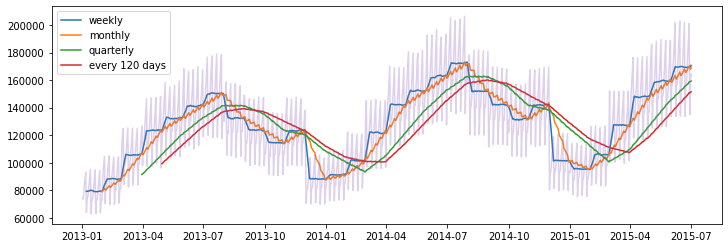

In [90]:
# train['sales_total'].tail(30)
plt.figure(figsize=(12,4))
plt.plot(train['sales_total'].rolling(7).mean(), label = 'weekly')
plt.plot(train['sales_total'].rolling(30).mean(), label = 'monthly')
plt.plot(train['sales_total'].rolling(90).mean(), label = 'quarterly')
plt.plot(train['sales_total'].rolling(120).mean(), label = 'every 120 days')
plt.plot(train['sales_total'], alpha=.3)
plt.legend()
plt.show()

In [94]:
# demonstrate that the mean of the first 30 days 
# is equal to rolling(30) on day 30

print(train['sales_total'].rolling(30).mean()[29])
print(train['sales_total'].head(30).mean())

78937.69766666666
78937.69766666666


**Make Predictions**

In [97]:
period = 30
def get_predicted_val(period):
    
    dollars = round(train['sales_total'].rolling(period).mean()[-1], 2)

    items = round(train['quantity'].rolling(period).mean()[-1], 2)
    
    return dollars, items



In [99]:
dollars, items = get_predicted_val(30)

print(dollars, items)

168957.91 31432.77


In [101]:
yhat_df = make_predictions()
yhat_df

,sales_total,quantity
sale_date,,
2015-07-02 00:00:00+00:00,168957.91,31432.77
2015-07-03 00:00:00+00:00,168957.91,31432.77
2015-07-04 00:00:00+00:00,168957.91,31432.77
2015-07-05 00:00:00+00:00,168957.91,31432.77
2015-07-06 00:00:00+00:00,168957.91,31432.77
...,...,...
2016-12-26 00:00:00+00:00,168957.91,31432.77
2016-12-27 00:00:00+00:00,168957.91,31432.77
2016-12-28 00:00:00+00:00,168957.91,31432.77


**Plot Actual vs. Predicted Values**

- Now, let's plot and evaluate the performance of our time series model using **Moving Average**

quantity --RMSE: 6954


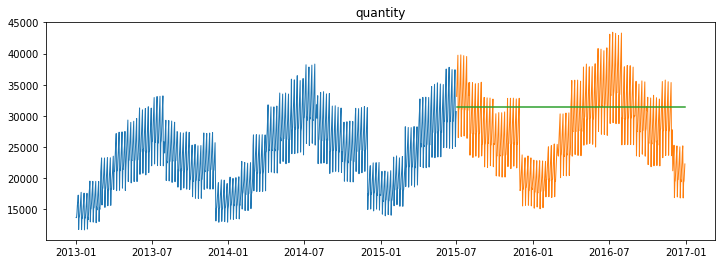

sales_total --RMSE: 37378


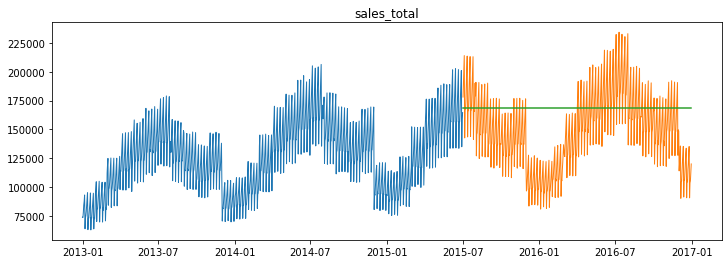

In [102]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate**
- Evaluate using RMSE and add evaluation metrics to the dataframe

In [103]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
1,last_observed_value,sales_total,35402.0
2,simple_average,quantity,7378.0
3,simple_average,sales_total,39664.0
4,30d_moving_avg,quantity,6954.0
5,30d_moving_avg,sales_total,37378.0


In [104]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    dollars = round(train['sales_total'].rolling(p).mean()[-1], 2)
    items = round(train['quantity'].rolling(p).mean()[-1],2)
    yhat_df = make_predictions()
    model_type = str(p) + 'd_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type, 
                                 target_var = col)

In [105]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,6621.0
1,last_observed_value,sales_total,35402.0
2,simple_average,quantity,7378.0
3,simple_average,sales_total,39664.0
4,30d_moving_avg,quantity,6954.0
5,30d_moving_avg,sales_total,37378.0
6,4d_moving_avg,quantity,6592.0
7,4d_moving_avg,sales_total,35515.0
8,12d_moving_avg,quantity,6992.0
9,12d_moving_avg,sales_total,37644.0


Which is best so far?

In [107]:
min_items_rmse = eval_df[eval_df.target_var == 'quantity']['rmse'].min()

eval_df[eval_df.rmse == min_items_rmse]

,model_type,target_var,rmse
14,104d_moving_avg,quantity,6101.0


## Holt's Linear Trend

- Exponential smoothing applied to both the average and the trend (slope).
    - $\alpha$ / smoothing_level: smoothing parameter for mean. Values closer to 1 will have less of a smoothing effect and will give greater weight to recent values.
    - $\beta$ / smoothing_slope: smoothing parameter for the slope. Values closer to 1 will give greater weight to recent slope/values.
    
**Seasonal Decomposition**

First, let's take a look at the seasonal decomposition for each target.


quantity 



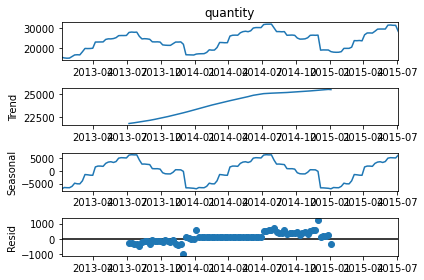

sales_total 



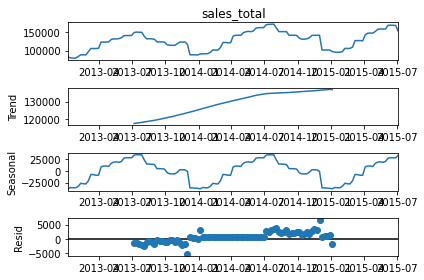

In [109]:
for col in train.columns:
    print(col, '\n')
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()
    plt.tight_layout()
    plt.show()